
# Nombre del Proyecto: Clasificador de Imágenes Piedra, Papel o Tijera con MLP

## Instalación del Dataset y Requerimientos

1. **Extnsiones en VS Code**: 
    - Descarga la extensión de Jupyter en VS code. 


2. **Requerimientos**:
    - Asegúrate de tener Python instalado (versión 3.11 o superior).
    - Instala las siguientes bibliotecas necesarias para el proyecto:
      ```bash
      pip install -r requirements.txt
      ```

3. **Ejecutar**:
    - Click en Run All

## Importación de dependencias

In [295]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

# Set random seed for reproducible results
tf.random.set_seed(22)
np.random.seed(22)

Python version: 3.11.0
Tensorflow version: 2.19.0
Keras version: 3.9.2


## Cargando el dataset

Se va a descargar el dataset Rock-Paper-Scissors de la colección TensorFlow Datasets. Para eso se descargó el módulo tensorflow_datasets.

tensorflow_datasets define una colección de datasets listos para usar con TensorFlow.

Cada conjunto de datos se define como un tfds.core.DatasetBuilder, que encapsula la lógica para descargar el conjunto de datos y construir un pipeline de entrada, además de contener la documentación del conjunto de datos (versión, divisiones, número de ejemplos, etc.).

In [296]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\proy1_ia_modelo\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [297]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 

Raw test dataset size: 372 



In [298]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='tmp\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

In [299]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [300]:
# Función para convertir label ID a cadenas de etiquetas.
get_label_name = dataset_info.features['label'].int2str
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


## Explorando el dataset

In [301]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

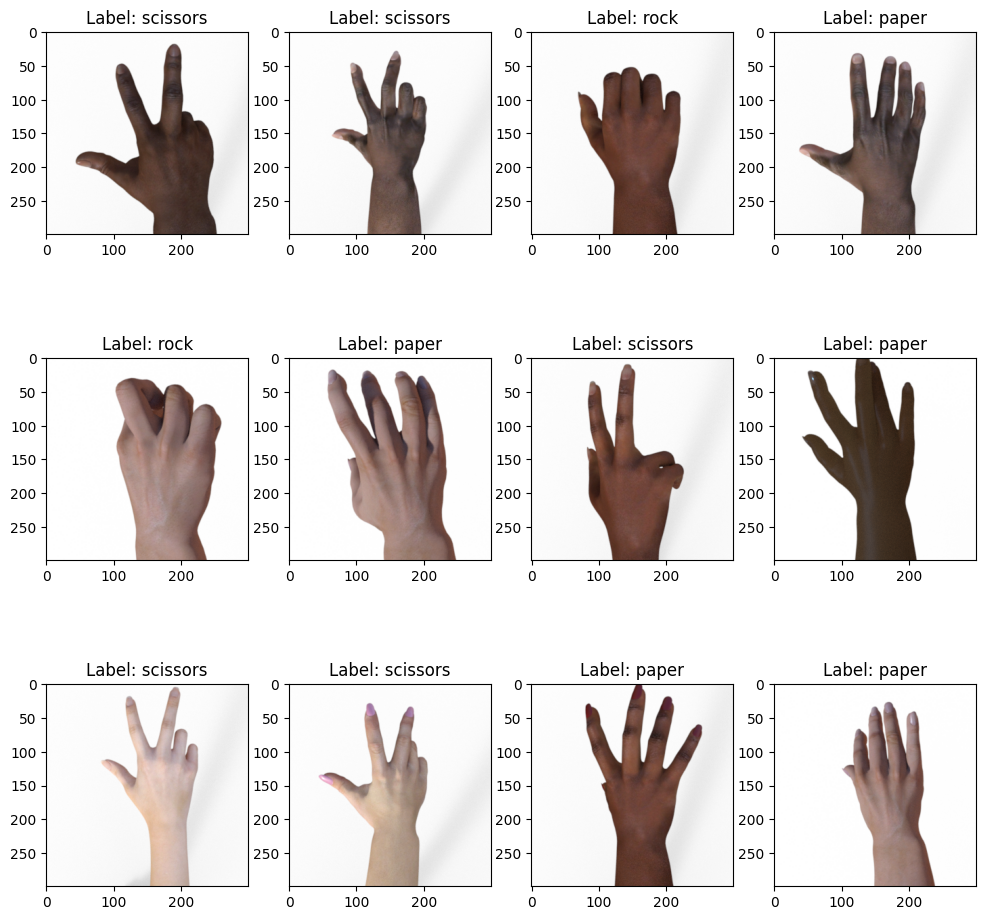

In [302]:
# Explorando las imagenes del dataset. 
preview_dataset(dataset_train_raw)

## Generando el dataset de landmarks
La idea es entrenar al modelo en base a las posiciones de los landmarks de las manos

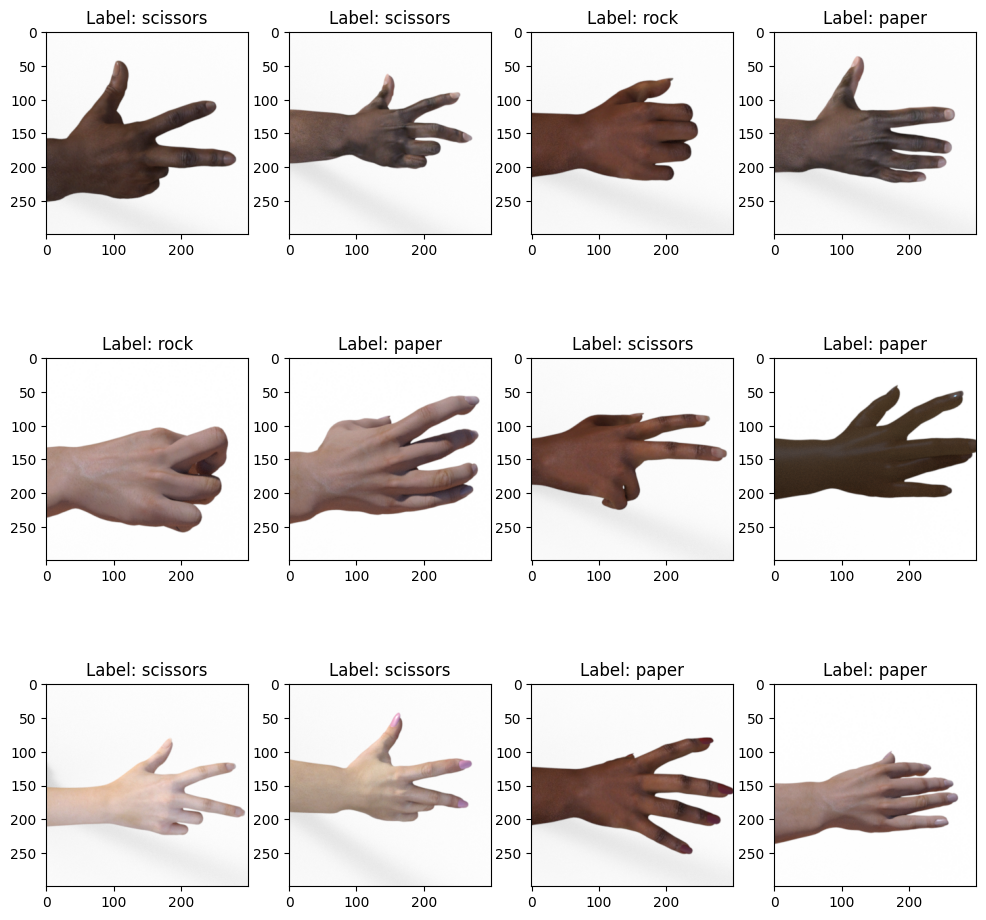

In [303]:
def transform_images(image, label):
    """Transformaciones para mejorar el modelo en el juego"""
    # Voltear todas las imágenes 90° hacia la derecha.
    image = tf.image.rot90(image)
    # Flip vertical de las imágenes
    image = tf.image.flip_up_down(image)
    # Flip horizontal de las imágenes
    image = tf.image.flip_left_right(image)
    return image, label

# Aplicar la función de rotación a todas las imágenes del dataset.
dataset_train_raw = dataset_train_raw.map(transform_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test_raw = dataset_test_raw.map(transform_images, num_parallel_calls=tf.data.AUTOTUNE)

# Explorando las imagenes del dataset.
preview_dataset(dataset_train_raw)

In [304]:
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.4,
    min_tracking_confidence=0.4,
)

def image_to_landmarks_list(image: tf.Tensor | np.ndarray):
    # Convert the image to a numpy array
    if not isinstance(image, np.ndarray):
        image_np = image.numpy()
    else:
        image_np = image
    # Process the image with MediaPipe Hands
    results = hands.process(image_np)
    if results.multi_hand_landmarks:
        # Extract the first hand's landmarks
        hand_landmarks = results.multi_hand_landmarks[0]
        # Convert landmarks to a list of (x, y, z) tuples
        landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
        # Flatten the list of tuples
        landmarks = [coord for landmark in landmarks for coord in landmark]
        return landmarks
    else:
        return None

def extract_landmarks_from_dataset(dataset):
    landmarks_list = []
    for image, label in dataset:
        landmarks = image_to_landmarks_list(image)
        if landmarks is None:
            continue
        
        landmarks_list.append((landmarks, label))
    # Convert landmarks and labels to numpy arrays for compatibility
    landmarks_array = np.array([landmarks for landmarks, label in landmarks_list], dtype=np.float32)
    labels_array = np.array([label.numpy() for landmarks, label in landmarks_list], dtype=np.int64)
    
    return tf.data.Dataset.from_tensor_slices((landmarks_array, labels_array))

In [305]:
# Convert the raw datasets to landmarks datasets
landmarks_train_dataset = extract_landmarks_from_dataset(dataset_train_raw)
landmarks_test_dataset = extract_landmarks_from_dataset(dataset_test_raw)

NUM_TRAIN_EXAMPLES = len(landmarks_train_dataset)
NUM_TEST_EXAMPLES = len(landmarks_test_dataset)

print("Landmarks train dataset size:", NUM_TRAIN_EXAMPLES)
print("Landmarks test dataset size:", NUM_TEST_EXAMPLES)

for landmarks, label in landmarks_train_dataset.take(1):
    print("Landmarks:", landmarks.numpy())
    print("Label:", label.numpy())
    print("Label Name:", get_label_name(label.numpy()))
    print()

Landmarks train dataset size: 2406
Landmarks test dataset size: 369
Landmarks: [ 1.45358294e-01  6.80580258e-01  1.92281937e-06  2.23243028e-01
  5.02274871e-01  2.44099516e-02  2.99212813e-01  3.91251922e-01
 -1.64029505e-02  3.33482444e-01  2.82468736e-01 -4.24082465e-02
  3.65199924e-01  1.73786700e-01 -6.14249259e-02  4.69409853e-01
  5.03320754e-01 -1.75760567e-01  6.25892758e-01  4.33419764e-01
 -1.98736280e-01  7.31218576e-01  3.89152378e-01 -2.13587254e-01
  8.11322570e-01  3.65047753e-01 -2.28343800e-01  4.78310227e-01
  6.01677477e-01 -1.36533082e-01  6.78809762e-01  6.15092397e-01
 -1.58547461e-01  7.99987495e-01  6.18064344e-01 -1.52694717e-01
  8.92499864e-01  6.29223883e-01 -1.58967391e-01  4.65834320e-01
  6.85942173e-01 -6.81715310e-02  5.73643506e-01  6.59596920e-01
  4.60035987e-02  4.97548640e-01  6.31904960e-01  1.54079854e-01
  4.42119449e-01  6.28604412e-01  1.96184441e-01  4.65203166e-01
  7.51524091e-01 -1.80590828e-03  5.36559522e-01  7.33420491e-01
  1.1987036

In [306]:
VALIDATION_SPLIT = 0.2

# Dividir el conjunto de entrenamiento en entrenamiento y validación
def split_dataset(dataset, validation_split):
    dataset_size = len(dataset)
    validation_size = int(dataset_size * validation_split)

    validation_dataset = dataset.take(validation_size)
    train_dataset = dataset.skip(validation_size)

    return train_dataset, validation_dataset

train_dataset, validation_dataset = split_dataset(landmarks_train_dataset, VALIDATION_SPLIT)

# Imprimir tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(validation_dataset))
print("Tamaño del conjunto de prueba:", len(landmarks_test_dataset))

Tamaño del conjunto de entrenamiento: 1925
Tamaño del conjunto de validación: 481
Tamaño del conjunto de prueba: 369


## Barajado de datos y procesamiento por lotes 

No se quiere que el modelo aprenda algo del orden o la agrupación de las imágenes en el conjunto de datos. Para evitarlo, se va a barajear los ejemplos de entrenamiento. También se va a dividir el conjunto de entrenamiento por lotes para hacer el proceso de entrenamiento más rápido y que consuma menos memoria. 

In [307]:
BATCH_SIZE = 32

train_shuffled = (
    train_dataset.shuffle(buffer_size=train_dataset.cardinality())
    .batch(batch_size=BATCH_SIZE)
    .prefetch(
        # Prefetch permitirá que el pipeline de entrada obtenga lotes de forma asincrónica mientras su modelo está entrenando.
        buffer_size=tf.data.experimental.AUTOTUNE
    )
)

validation_shuffled = validation_dataset.batch(BATCH_SIZE).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

test_shuffled = landmarks_test_dataset.batch(BATCH_SIZE).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

## Creando el modelo 

In [308]:
model = tf.keras.models.Sequential(name="rock_paper_scissors_mlp")

# Aplanar los resultados para alimentar las capas densas.
model.add(tf.keras.layers.Flatten())

# Capas ocultas
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=700, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))

# Capa de salida.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [309]:
model.summary()

Model: "rock_paper_scissors_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compilando el modelo 

In [331]:
# Se usa el optimizador Adam para la optimización del modelo.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [332]:
steps_per_epoch = len(train_dataset) // BATCH_SIZE
validation_steps = len(validation_dataset) // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 60
validation_steps: 15


In [333]:
# Preparando los callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras'
)

# Parada temprana
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [334]:
# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

training_history = model.fit(
    x=train_shuffled,
    validation_data=validation_shuffled,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9609 - loss: 0.1436 - val_accuracy: 0.9917 - val_loss: 0.0233
Epoch 2/15
 1/60 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 1.0000 - loss: 4.7538e-05

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\proy1_ia_modelo\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.7538e-05 - val_accuracy: 0.9771 - val_loss: 0.0631
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9889 - loss: 0.0446 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4972e-05 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9870 - loss: 0.0328 - val_accuracy: 0.9937 - val_loss: 0.0113
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9855 - loss: 0.0370 - val_accuracy: 0.9958 - val_loss: 0.0091
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.2666e-04 - val_accuracy: 0.9958 - val_loss: 0.0106
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9888 - loss: 0.0336 - val_accuracy: 1.0000 - val_

In [335]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

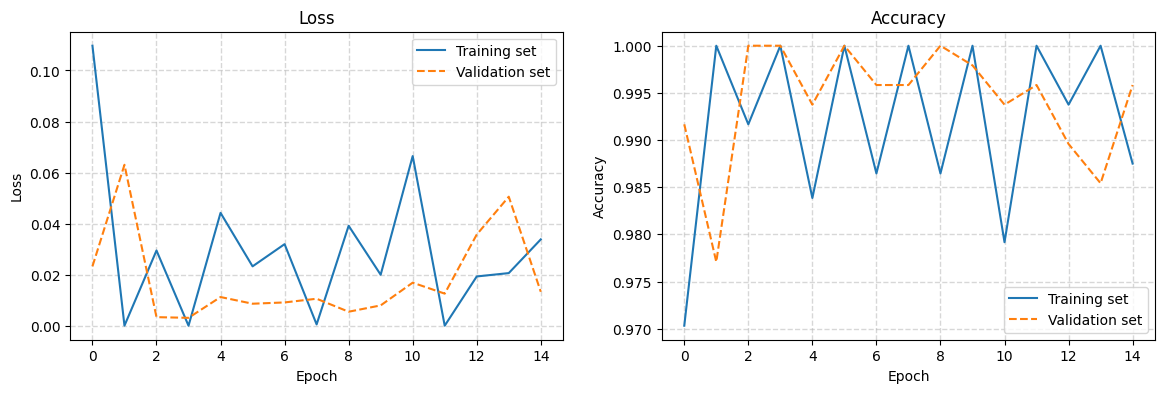

In [336]:
render_training_history(training_history)

## Evaluando la precisión del modelo 

In [337]:
# Evaluar con el conjunto de test
test_loss, test_accuracy = model.evaluate(
    x=landmarks_test_dataset.batch(BATCH_SIZE)
)

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8251 - loss: 0.5448

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8119 - loss: 0.5647


In [338]:
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Test loss:  0.619631826877594
Test accuracy:  0.7804877758026123


## Guardando el modelo 

In [339]:
model_name = 'rock_paper_scissors_mlp.h5'
model.save(model_name, save_format='h5')

## Probando el modelo con imagenes externas

In [340]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('rock_paper_scissors_mlp.h5')

In [341]:
from PIL import Image

def preprocess_image(image_path):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Convertir la imagen a un array de NumPy
    img_array = np.array(img)
    return image_to_landmarks_list(img_array)

In [342]:
# Ruta de la imagen a probar
image_path = 'tijera.png'

# Preprocesar la imagen
input_image = preprocess_image(image_path)

# Convertir la lista de landmarks a un array de NumPy y agregar una dimensión de lote
input_image = np.array(input_image, dtype=np.float32)
input_image = np.expand_dims(input_image, axis=0)

# Hacer la predicción
predictions = model.predict(input_image)

print('Predicciones:', predictions)

# Obtener la clase con mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)[0]

print(f'Predicción: Clase {predicted_class}')

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\proy1_ia_modelo\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicciones: [[6.5510074e-04 1.9444801e-01 8.0489689e-01]]
Predicción: Clase 2


In [343]:
# Convertir la clase predicha a su etiqueta
label_name = get_label_name(predicted_class)
print(f'La imagen pertenece a la clase: {label_name}')

La imagen pertenece a la clase: scissors


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


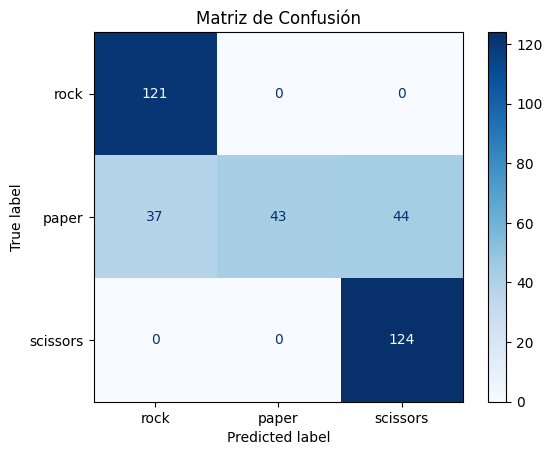

In [344]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones y etiquetas reales
true_labels = []
predicted_labels = []

for landmarks, label in landmarks_test_dataset.batch(BATCH_SIZE):
    predictions = model.predict(landmarks)
    predicted_classes = np.argmax(predictions, axis=1)

    true_labels.extend(label.numpy())
    predicted_labels.extend(predicted_classes)

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels, labels=range(NUM_CLASSES))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=[get_label_name(i) for i in range(NUM_CLASSES)]
).plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()